In [2]:
# Installing TensorFlow library for the project

!pip install tensorflow
!rm -rf ./*
!git clone https://github.com/ArunSaiNarla/CVCourseEndProject.git
!mv CVCourseEndProject/* ./

Cloning into 'CVCourseEndProject'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 146 (delta 16), reused 131 (delta 9), pack-reused 0
Receiving objects: 100% (146/146), 25.35 MiB | 34.99 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [3]:
# Importation of the Datasets and Libraries

import os
import glob
import numpy as np
from PIL import Image, ImageOps
import tensorflow as tf
import matplotlib.pyplot as plt

from datasets.div2k.parameters import Div2kParameters
from models.srgan_generator import build_srresnet
from models.pretrained import pretrained_models
from utils.prediction import get_sr_image
from utils.config import config

In [4]:
# Obtaining the Path

dataset_key = "bicubic_x4"

data_path = config.get("data_path", "")

div2k_folder = os.path.abspath(os.path.join(data_path, "div2k"))

dataset_parameters = Div2kParameters(dataset_key, save_data_directory=div2k_folder)

In [5]:
def load_image(path):
    img = Image.open(path)

    was_grayscale = len(img.getbands()) == 1

    if was_grayscale or len(img.getbands()) == 4:
        img = img.convert('RGB')

    return was_grayscale, np.array(img)

In [16]:
# Defining the Model name

model_name = "srresnet"
model_key = f"{model_name}_{dataset_key}"

In [24]:
# Loading the weights
weights_directory = os.path.abspath(f"weights/{model_key}")
file_path = os.path.join(weights_directory, "generator.h5")

if not os.path.exists(file_path):
    os.makedirs(weights_directory, exist_ok=True)

    print("Couldn't find file:", file_path, ", attempting to download a pretrained model")

    if model_key not in pretrained_models:
        print(f"Couldn't find pretrained model with key: {model_key}, available pretrained models: {list(pretrained_models.keys())}")
    else:
        download_url = pretrained_models[model_key]
        file = "generator.h5"
        tf.keras.utils.get_file(file, download_url, cache_subdir=weights_directory)


In [25]:
# Model Building

from models.srgan_generator import build_srresnet

# Build the SRResNet model
model = build_srresnet(scale=dataset_parameters.scale)

# Ensure the directory for weights exists
weights_directory = '/content/weights/srgan_bicubic_x4'
os.makedirs(weights_directory, exist_ok=True)

# Specify the weights file with the correct path
weights_file = f'{weights_directory}/generator.h5'

# Check if the weights file exists before attempting to load
if os.path.exists(weights_file):
    try:
        # Load only the weights into the model, ignoring any potential layer count mismatch
        model.load_weights(weights_file, by_name=True)
        print("Weights loaded successfully.")
    except Exception as e:
        print(f"Error loading weights: {e}")
else:
    print(f"Error: The weights file '{weights_file}' does not exist.")


Weights loaded successfully.


In [26]:
# Obtaining Results Path

results_path = f"output/{model_key}/"
os.makedirs(results_path, exist_ok=True)

In [27]:
# Splitting them

image_paths = glob.glob("input/*")

for image_path in image_paths:
    print(image_path)
    was_grayscale, lr = load_image(image_path)

    sr = get_sr_image(model, lr)

    if was_grayscale:
        sr = ImageOps.grayscale(sr)

    image_name = image_path.split("/")[-1]
    sr.save(f"{results_path}{image_name}" )

input/4.png
1/1 [==============================] - 2s 2s/step
input/5.png
1/1 [==============================] - 1s 1s/step
input/2.png
1/1 [==============================] - 1s 1s/step
input/1.png
1/1 [==============================] - 1s 1s/step
input/3.png
1/1 [==============================] - 2s 2s/step
input/0.png
1/1 [==============================] - 2s 2s/step


In [28]:
# Zipping the output Images

!zip -r images.zip output

updating: output/ (stored 0%)
updating: output/srgan_bicubic_x4/ (stored 0%)
updating: output/srgan_bicubic_x4/4.png (deflated 0%)
updating: output/srgan_bicubic_x4/5.png (deflated 0%)
updating: output/srgan_bicubic_x4/2.png (deflated 0%)
updating: output/srgan_bicubic_x4/1.png (deflated 0%)
updating: output/srgan_bicubic_x4/3.png (deflated 0%)
updating: output/srgan_bicubic_x4/0.png (deflated 0%)
updating: output/srresnet_bicubic_x4/ (stored 0%)
updating: output/srresnet_bicubic_x4/4.png (deflated 0%)
updating: output/srresnet_bicubic_x4/5.png (deflated 0%)
updating: output/srresnet_bicubic_x4/2.png (deflated 0%)
updating: output/srresnet_bicubic_x4/1.png (deflated 0%)
updating: output/srresnet_bicubic_x4/3.png (deflated 0%)
updating: output/srresnet_bicubic_x4/0.png (deflated 0%)


PSNR-HR PSNR-SRGAN  PSNR-SRRESNET  MSE-SRGAN  MSE-SRRESNET   SSIM-SRGAN  SSIM-SRRESNET


<ipython-input-29-f4604f0b6a71>:35: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return ssim1(img1,img2,data_range=255,multichannel=True)


100.000    27.908        27.874     1.053       1.061            0.016         0.027
100.000    27.921        27.867     1.049       1.063            0.014         0.022
100.000    27.888        27.871     1.058       1.062            0.013         0.021
100.000    27.893        27.858     1.056       1.065            0.024         0.046
100.000    27.923        27.915     1.049       1.051            0.015         0.024
100.000    27.872        27.895     1.061       1.056            0.016         0.027


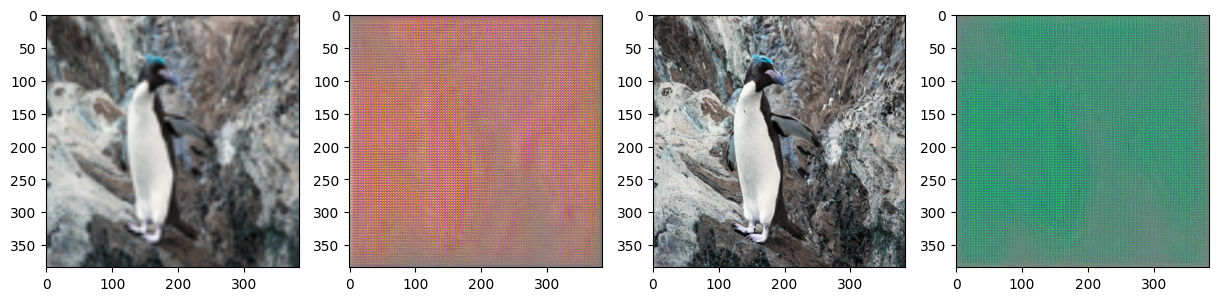

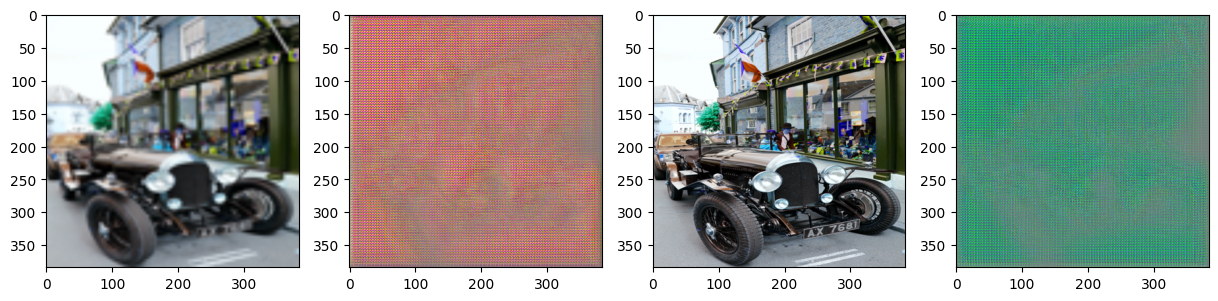

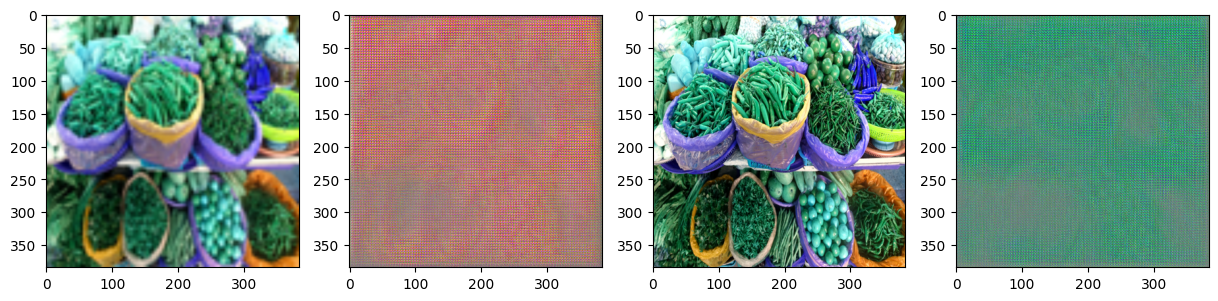

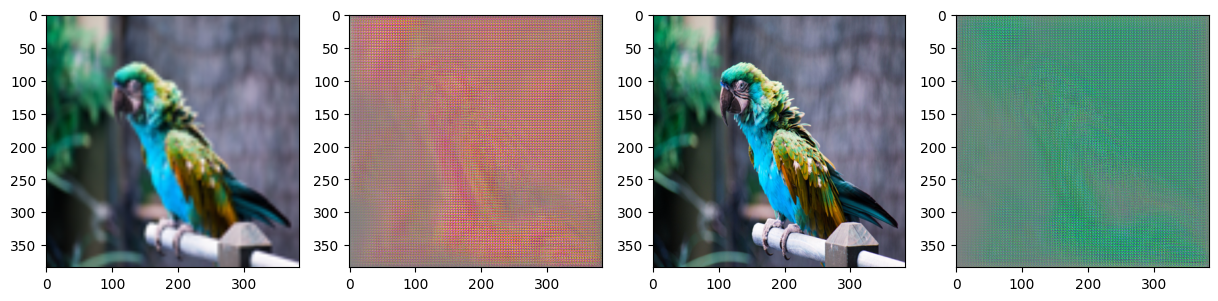

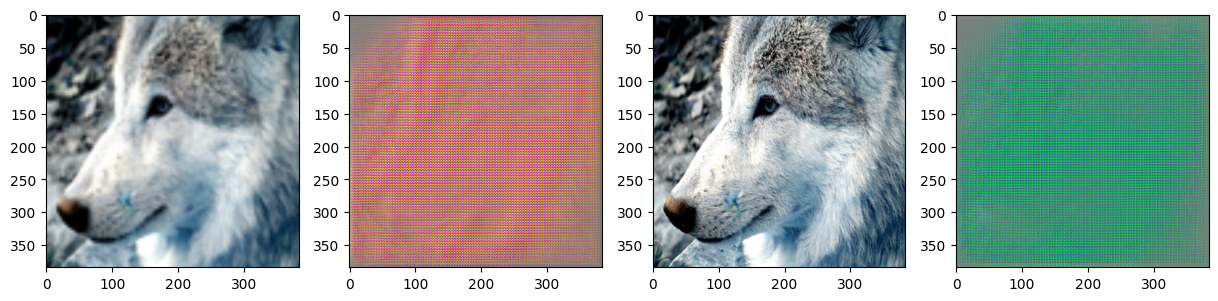

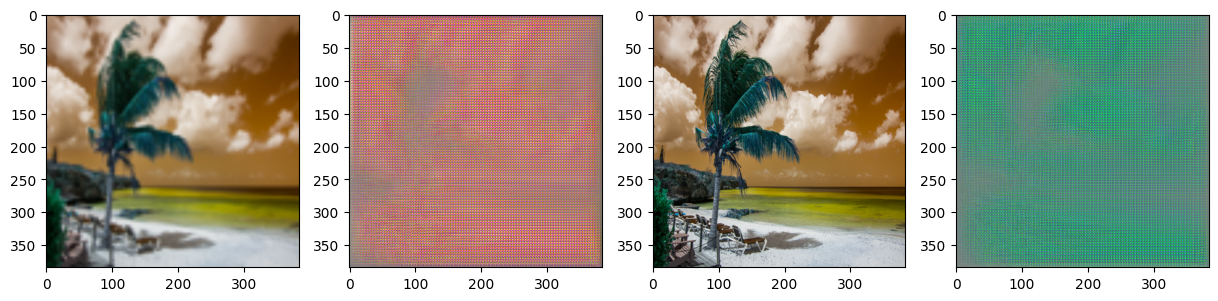

In [29]:
from math import log10, sqrt

import cv2
from skimage.metrics import structural_similarity as ssim1
from skimage.metrics import mean_squared_error as mse


# Calculating PSNR of the Images

def PSNR(original, compressed):

    mse = np.mean((original - compressed) ** 2)

    if(mse == 0):  # MSE is zero means no noise is present in the signal .

                  # Therefore PSNR have no importance.

        return 100

    max_pixel = 255.0

    psnr = 20 * log10(max_pixel / sqrt(mse))

    return psnr

# Calculating MSE of the Images

def mse(original, compressed):
    m = np.mean((original - compressed) ** 2)*0.01
    return m

# Calculating SSIM of the Images

def ssim(img1, img2):
  return ssim1(img1,img2,data_range=255,multichannel=True)

cols = 3
if model_name == "srgan":
  cols = 3
  print("PSNR-HR  PSNR-SRGAN  MSE-SRGAN    SSIM-SRGAN")
else:
  cols = 4
  print("PSNR-HR PSNR-SRGAN  PSNR-SRRESNET  MSE-SRGAN  MSE-SRRESNET   SSIM-SRGAN  SSIM-SRRESNET")

num_img=len(os.listdir("input"))
for i in range(num_img):
  fig, axes = plt.subplots(nrows=1, ncols=cols, figsize=(15,15))
  original = cv2.imread(f"input/{i}.png")

  resized = cv2.resize(original, (384, 384))
  axes[0].imshow(resized)
  hr_normal = cv2.imread(f"HR/{i}.png", 1)
  axes[2].imshow(hr_normal)
  hr_gan = cv2.imread(f"output/srgan_bicubic_x4/{i}.png", 1)
  axes[1].imshow(hr_gan)

  if model_name == "srgan":
    print(f"{PSNR(hr_normal,hr_normal):.3f}    {PSNR(hr_normal, hr_gan):.3f}       {mse(hr_normal,hr_gan):.3f}        {ssim(hr_normal,hr_gan):.3f} ")
  else:
    hr_resnet = cv2.imread(f"output/srresnet_bicubic_x4/{i}.png", 1)
    axes[3].imshow(hr_resnet)
    print(f"{PSNR(hr_normal,hr_normal):.3f}    {PSNR(hr_normal, hr_gan):.3f}        {PSNR(hr_normal, hr_resnet):.3f}     {mse(hr_normal,hr_gan):.3f}       {mse(hr_normal,hr_resnet):.3f}            {ssim(hr_normal,hr_gan):.3f}         {ssim(hr_normal,hr_resnet):.3f}")